In [431]:
import geopandas as gpd
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import plotly.express as px
%matplotlib inline
import types
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from pandas import to_datetime
from fbprophet import Prophet


import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


## Collection events

In [5]:
#waste_aust = pd.read_csv(r'C:\Users\fredericorodrigues\Downloads\waste_collection.csv')  
waste_aust = pd.read_csv('data/waste_collection.csv')  

In [6]:
waste_aust.dtypes

Report Date      object
Load Type        object
Load Time        object
Load Weight     float64
Dropoff Site     object
Route Type       object
Route Number     object
Load ID           int64
dtype: object

In [7]:
waste_aust['Load Time'] = pd.to_datetime(waste_aust['Load Time'])
waste_aust['Report Date'] = pd.to_datetime(waste_aust['Report Date'])

In [8]:
cal = calendar()
holidays = cal.holidays(start=waste_aust['Load Time'].min(), end=waste_aust['Load Time'].max())

waste_aust['Holiday'] = waste_aust['Load Time'].isin(holidays)

In [9]:
waste_aust['DoW'] = waste_aust['Load Time'].dt.day_name()

waste_aust.head()

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Holiday,DoW
0,2020-12-08,BULK,2020-12-08 15:02:00,5220.0,TDS LANDFILL,BULK,BU13,899097,False,Tuesday
1,2020-12-08,RECYCLING - SINGLE STREAM,2020-12-08 10:00:00,11140.0,TDS - MRF,RECYCLING - SINGLE STREAM,RTAU53,899078,False,Tuesday
2,2020-12-03,RECYCLING - SINGLE STREAM,2020-12-03 10:34:00,10060.0,BALCONES RECYCLING,RECYCLING - SINGLE STREAM,RHBU10,899082,False,Thursday
3,2020-12-07,SWEEPING,2020-12-07 10:15:00,7100.0,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,899030,False,Monday
4,2020-12-07,RECYCLING - SINGLE STREAM,2020-12-07 16:00:00,12000.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMAU53,899048,False,Monday


In [10]:
df = waste_aust.copy()

### Forecast - SARIMAX with Exogenous Variables

In [127]:
licencesdf  = pd.read_csv('data/licences.csv')#,header = 1)
licencesdf.head(3)

,Unnamed: 0,Permit Type Desc,Permit Num,Permit Class Mapped,Permit Class,Work Class,Condominium,Project Name,Description,Applied Date,Issued Date,Calendar Year Issued,Status Current,Status Date,Expires Date,Completed Date,Location
0,23,Electrical Permit,2007-132615 EP,Residential,Residential,New,No,5806 CAROLINE LN,new sf residence watt garage electric service EUD,2007/06/28,2007/06/28,2007,Final,10/09/2008,2007/07/17,2007/07/17,"(30.25687156, -97.57498898)"
1,170,Electrical Permit,2010-013963 EP,Residential,Residential,New,No,4613 CREDO LN,New 2 story sf residence with attached garage ...,2010/02/19,2010/02/19,2010,Final,02/22/2010,2010/02/22,2010/02/22,"(30.23821171, -97.57086234)"
2,370,Electrical Permit,2012-083545 EP,Commercial,C- 328 Commercial Other Nonresident Bldg,New,No,3412 W WILLIAM CANNON DR,vaccum enclosure with cover and add 2 lights b...,2010/09/30,2012/09/07,2012,Final,09/12/2012,2012/09/12,2012/09/12,"(30.21328212, -97.82858596)"


In [128]:
licencesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554699 entries, 0 to 554698
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            554699 non-null  int64 
 1   Permit Type Desc      554699 non-null  object
 2   Permit Num            554699 non-null  object
 3   Permit Class Mapped   554699 non-null  object
 4   Permit Class          554699 non-null  object
 5   Work Class            554699 non-null  object
 6   Condominium           554343 non-null  object
 7   Project Name          545396 non-null  object
 8   Description           554687 non-null  object
 9   Applied Date          554687 non-null  object
 10  Issued Date           554699 non-null  object
 11  Calendar Year Issued  554699 non-null  int64 
 12  Status Current        554699 non-null  object
 13  Status Date           554699 non-null  object
 14  Expires Date          554699 non-null  object
 15  Completed Date   

In [129]:
residential = licencesdf[(licencesdf['Permit Class Mapped']=='Residential')&(~licencesdf['Completed Date'].isna())][['Completed Date','Permit Num']].copy()
residential['Completed Date'] = pd.to_datetime(residential['Completed Date'], format='%Y/%m/%d')
residential['Completed Date'] = residential['Completed Date'].dt.strftime('%Y-%m')
residential = residential.groupby('Completed Date')['Permit Num'].count().reset_index()
residential

In [210]:
residential2 = licencesdf[(licencesdf['Permit Class Mapped']=='Residential')&(~licencesdf['Completed Date'].isna())][['Issued Date','Work Class']].copy()
residential2['Issued Date'] = pd.to_datetime(residential2['Issued Date'], format='%Y/%m/%d')
residential2['Issued Date'] = residential2['Issued Date'].dt.strftime('%Y-%m')
residential2 = residential2.groupby('Issued Date')['Work Class'].count().reset_index()
residential2

,Issued Date,Work Class
0,1970-08,1
1,1971-04,4
2,1977-03,4
3,1977-10,4
4,1978-01,5
...,...,...
523,2021-11,79
524,2021-12,44
525,2022-01,43
526,2022-02,18


In [130]:
inputdf = pd.read_csv('data/gt.csv',header = 1).rename(columns={'Mês': 'Month','Mudanças climáticas: (Austin TX)': 'Climate_Change' })

In [214]:
# creating a Dataset with daily values
waste = waste_aust[['Load Time','Load Weight']].copy()
waste['Load Time'] = waste['Load Time'].dt.strftime('%Y-%m')
waste = waste.groupby('Load Time')['Load Weight'].sum().reset_index()

In [132]:
waste[waste['Load Time'] > '2021-01']

,Load Time,Load Weight
203,2021-02,3.725125e+07
204,2021-03,6.490663e+07
205,2021-04,5.096346e+07
206,2021-05,4.762450e+07
207,2021-06,4.945469e+07
208,2021-07,1.144997e+07
209,2021-12,8.280000e+03
210,2030-07,2.600000e+02
211,2030-11,3.200000e+02


In [133]:
unemployment = pd.read_csv('data/BLSunemployment_Austin.csv')
unemployment['year/month']=unemployment['Year'].map(str) +'-' +unemployment['Period'].map(str) 
unemployment['year/month'] = pd.to_datetime(unemployment['year/month'])
unemployment['year/month'] = unemployment['year/month'].dt.strftime('%Y-%m')
unemployment.head()

,Year,Period,labor force participation rate,employment-population ratio,labor force,employment,unemployment,unemployment rate,year/month
0,2010,Jan,66.3,60.8,12108919,11106882,1002037,8.3,2010-01
1,2010,Feb,66.4,60.9,12151988,11146453,1005535,8.3,2010-02
2,2010,Mar,66.5,61.0,12191275,11184615,1006660,8.3,2010-03
3,2010,Apr,65.9,60.5,12222661,11218075,1004586,8.2,2010-04
4,2010,May,65.9,60.6,12244873,11246029,998844,8.2,2010-05


In [134]:
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Year                            145 non-null    int64 
 1   Period                          145 non-null    object
 2   labor force participation rate  145 non-null    object
 3   employment-population ratio     145 non-null    object
 4   labor force                     145 non-null    object
 5   employment                      145 non-null    object
 6   unemployment                    145 non-null    object
 7   unemployment rate               145 non-null    object
 8   year/month                      145 non-null    object
dtypes: int64(1), object(8)
memory usage: 10.3+ KB


In [135]:
unemployment['employment'] = unemployment['employment'].str.replace('(R)', '', regex=False)
unemployment['employment'] = unemployment['employment'].str.replace('(P)', '', regex=False)
unemployment['employment'] = unemployment['employment'].str.replace('()', '', regex=False)
#'unemployment rate'
unemployment['employment'] = unemployment['employment'].astype(int)

In [136]:
unemployment['unemployment rate'] = unemployment['unemployment rate'].str.replace('(R)', '', regex=False)
unemployment['unemployment rate'] = unemployment['unemployment rate'].str.replace('(P)', '', regex=False)
unemployment['unemployment rate'] = unemployment['unemployment rate'].str.replace('()', '', regex=False)
#'unemployment rate'
unemployment['unemployment rate'] = unemployment['unemployment rate'].astype(float)

In [137]:
weather = pd.read_csv('data/weather.csv')

weather['date']= pd.to_datetime(weather['date'], infer_datetime_format=True)
weather['year/month']=weather['date'].dt.year.map(str) +'-' +weather['date'].dt.month.map(str) 
weather['year/month'] = pd.to_datetime(weather['year/month'] , format='%Y-%m').dt.strftime('%Y-%m')

weather.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,year/month
0,2015-01-01,3.1,1.7,3.9,10.4,0,NaN,17.3,NaN,NaN,NaN,2015-01
1,2015-01-02,4.2,3.3,5.6,3.6,0,0.0,15.5,NaN,1019.3,NaN,2015-01
2,2015-01-03,6.6,1.1,15.6,16.0,0,NaN,6.5,NaN,1015.9,NaN,2015-01
3,2015-01-04,6.0,-1.6,10.6,0.0,0,NaN,18.7,NaN,1031.0,NaN,2015-01
4,2015-01-05,1.9,-4.3,10.6,0.0,0,NaN,9.0,NaN,1036.4,NaN,2015-01


In [138]:
min_temp = weather.groupby(['year/month'])['tmin'].min().values
max_temp = weather.groupby(['year/month'])['tmax'].max().values
avg_temp = weather.groupby(['year/month'])['tavg'].mean().values
data={'Date':weather['year/month'].unique(),'Min':min_temp,'Max':max_temp,'Avg':avg_temp}
temp_df = pd.DataFrame(data)
temp_df.head()

,Date,Min,Max,Avg
0,2015-01,-6.0,26.7,7.754839
1,2015-02,-3.8,27.2,9.714286
2,2015-03,-6.0,27.8,14.445161
3,2015-04,6.7,32.8,20.646667
4,2015-05,8.9,31.1,22.887097


In [139]:

temp_df.columns

Index(['Date', 'Min', 'Max', 'Avg'], dtype='object')

In [140]:
avg_prcp = weather.groupby(['year/month'])['prcp'].mean().values
data={'Date':weather['year/month'].unique(),'Avg PRCP':avg_prcp}
prcp_df = pd.DataFrame(data)
prcp_df.head()

,Date,Avg PRCP
0,2015-01,4.325806
1,2015-02,0.421429
2,2015-03,3.309677
3,2015-04,1.990000
4,2015-05,11.012903


In [211]:
residential2.head()

,Issued Date,Work Class
0,1970-08,1
1,1971-04,4
2,1977-03,4
3,1977-10,4
4,1978-01,5


In [215]:
df = waste.reset_index().merge(inputdf, left_on='Load Time', right_on='Month')[['Load Time','Load Weight','Climate_Change']]
df = df.reset_index().merge(residential, left_on='Load Time', right_on='Completed Date')[['Load Time','Load Weight','Climate_Change','Permit Num']]
df = df.reset_index().merge(residential2, left_on='Load Time', right_on='Issued Date')[['Load Time','Load Weight','Climate_Change','Permit Num','Work Class']]
df = df.reset_index().merge(unemployment, left_on='Load Time', right_on='year/month')[['Load Time','Load Weight','Climate_Change','Permit Num','Work Class','employment','unemployment rate']]
df = df.reset_index().merge(temp_df, left_on='Load Time', right_on='Date')[['Load Time','Load Weight','Climate_Change','Permit Num','Work Class','employment','unemployment rate','Min', 'Max', 'Avg']]
df = df.reset_index().merge(prcp_df, left_on='Load Time', right_on='Date')[['Load Time','Load Weight','Climate_Change','Permit Num','Work Class','employment','unemployment rate','Min', 'Max', 'Avg','Avg PRCP']]

In [217]:
exogvar =  df.columns.drop(['Load Time', 'Load Weight'])
exogvar

Index(['Climate_Change', 'Permit Num', 'Work Class', 'employment',
       'unemployment rate', 'Min', 'Max', 'Avg', 'Avg PRCP'],
      dtype='object')

In [218]:
df['Load Time']  = pd.to_datetime(df['Load Time'], format='%Y-%m')

In [219]:
train_start = datetime(2010,2,1)
train_end = datetime(2018,12,31)
test_end = datetime(2020,1,1)

df = df.set_index('Load Time')

train_data = df[train_start:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [220]:
def visualizedata(df,column):
    fig = px.line(x=df.index, y=df[column], labels={'x':'Load Time', 'y':column})
    fig.show()
visualizedata(df,'Load Weight')

In [221]:
# Augmented Dickey-Fuller Test - Checking Stationarity
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

perform_adf_test(df['Load Weight'])

ADF Statistic: 1.388473
p-value: 0.997061


In [222]:
df['Load Weight'].isna().sum()

0

In [223]:
first_diff = df['Load Weight'].diff()[1:]
first_diff = pd.Series(first_diff,index=df['Load Weight'].iloc[1:].index)
perform_adf_test(first_diff)

ADF Statistic: -8.143005
p-value: 0.000000


In [224]:
acf_vals = acf(first_diff)
fig = px.bar(y=acf_vals)
fig.show()

In [225]:
pacf_vals = pacf(first_diff)
fig = px.bar(y=pacf_vals)
fig.show()

In [226]:
my_order = (1,1,1) #(p,d,q) (AR,I,MA)
my_seasonal_order = (1, 1, 1, 12) #

In [227]:
#sm.tsa.SARIMAX(df['Climate_Change'], order=(1,1,1))
my_order = (1,0,1) #(p,d,q) (AR,I,MA)
my_seasonal_order = (0, 1, 0, 12) #
trend = 'c'
'''A parameter for controlling a model of the deterministic trend as one of 
‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.'''

mod = sm.tsa.statespace.SARIMAX(
                                train_data['Load Weight'], train_data[exogvar],
                                order=my_order,
                                seasonal_order=my_seasonal_order,
                                trend=trend,
                                enforce_stationarity=True, 
                                enforce_invertibility=True
                               )
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Load Weight   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                -580.628
Date:                             Tue, 22 Mar 2022   AIC                           1187.255
Time:                                     18:07:39   BIC                           1207.841
Sample:                                 01-01-2015   HQIC                          1194.440
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -3.485e+04   2.25e+05     -0.155      0.877   -4.76e+05    4.06e+05
Climat

In [228]:
#get the predictions and residuals
fcast = res.get_forecast(steps=len(test_data),exog=test_data[exogvar])
predictions = fcast.predicted_mean
predictions_error = pd.Series(predictions)
residuals = test_data['Load Weight'] - predictions_error

In [229]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

Mean Absolute Percent Error: 0.0697


In [230]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 3749197.4077428333


In [231]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
CI = fcast.conf_int()
fig.add_traces([go.Scatter(x = CI.index, y = CI['lower Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = CI.index, y = CI['upper Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0697
Root Mean Squared Error: 3749197.4077428333


### GridSearch & Variable Analysis

In [268]:
def heatmap_pearson(df):
    corr = df
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(10, 10))
        for item in [f, ax]:
            item.patch.set_visible(False)
    ax = sns.heatmap(corr, mask=mask, square=True,cmap = plt.cm.Blues)
    plt.title('Pearson Correlation Matrix')
    plt.show()

In [430]:
#train_data

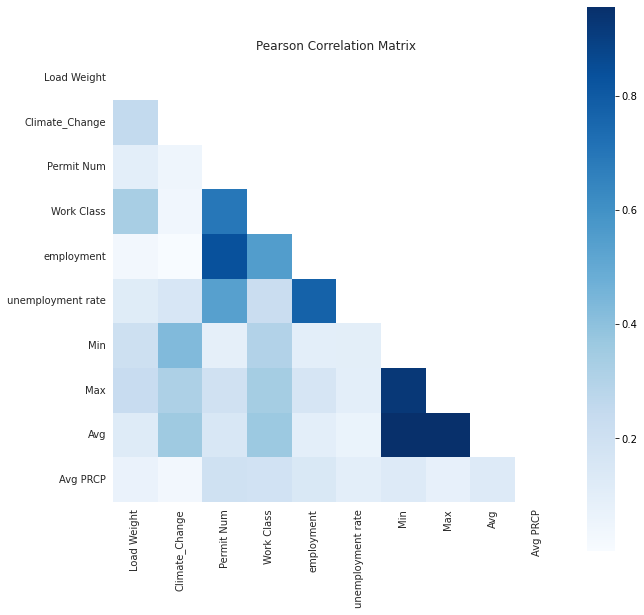

In [423]:
heatmap_pearson(train_data.corr(method='pearson').abs())

<b>The analysis on Correlation</b> 

It allows us to understand if we are getting the same information from diferent variables. In this case it is clear that all of the environmental variables are bringing the same information so we will only bring the Max temperature as it is the one with higher correlation with our target variable Load Weight

In [293]:
exogenousvar = exogvar.copy()
exogenousvar = exogenousvar.drop(['Min','Avg'])

In [ ]:
# define config lists
p_params = [0, 1]#, 2]
d_params = [0, 1]#, 2]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1]#, 2]
D_params = [0, 1]#, 2]
Q_params = [0, 1, 2]
m_params = [6,12]
models = list()
mapescore = list()
rmsescore = list()
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                mod = sm.tsa.statespace.SARIMAX(
                                                                train_data['Load Weight'], train_data[exogenousvar],
                                                                order=tuple([p,q,d]),
                                                                seasonal_order=tuple([P,Q,D,m]),
                                                                trend=t#,
                                                                #enforce_stationarity=True, 
                                                                #enforce_invertibility=True
                                                               )
                                res = mod.fit(disp=False)
                                #get the predictions and residuals
                                fcast = res.get_forecast(steps=len(test_data),exog=test_data[exogenousvar])
                                predictions = fcast.predicted_mean
                                predictions_error = pd.Series(predictions)
                                residuals = test_data['Load Weight'] - predictions_error
                                MAPE = round(np.mean(abs(residuals/test_data['Load Weight'])),4)
                                RMSE = np.sqrt(np.mean(residuals**2))
                                methods = tuple([p,q,d]),tuple([P,Q,D,m]),t
                                #print('(p,q,d)(P,Q,D,12)(trend)',methods,'MAPE: ', MAPE, 'RMSE: ', RMSE)
                                models.append(methods)
                                mapescore.append(MAPE)
                                rmsescore.append(RMSE)

<b>GridSearch</b> 

This gridsearch was inspired by the on in the following link: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [294]:
zipped = list(zip(models, mapescore, rmsescore))
table = pd.DataFrame(zipped, columns=['Model', 'MAPE', 'RMSE'])
table.head()
table.describe()
table.sort_values(by='MAPE',ascending=True).head(25)

,Model,MAPE,RMSE
17,"((0, 0, 0), (1, 2, 0, 12), n)",0.0361,1.933926e+06
41,"((0, 0, 0), (1, 2, 0, 12), c)",0.0370,1.987382e+06
11,"((0, 0, 0), (0, 2, 1, 12), n)",0.0497,2.281866e+06
5,"((0, 0, 0), (0, 2, 0, 12), n)",0.0501,2.295700e+06
47,"((0, 0, 0), (1, 2, 1, 12), c)",0.0502,2.290336e+06
311,"((0, 0, 1), (1, 2, 1, 12), n)",0.0502,2.397294e+06
35,"((0, 0, 0), (0, 2, 1, 12), c)",0.0502,2.290357e+06
293,"((0, 0, 1), (0, 2, 0, 12), n)",0.0503,2.335845e+06
581,"((1, 0, 0), (0, 2, 0, 12), n)",0.0504,2.336590e+06
605,"((1, 0, 0), (0, 2, 0, 12), c)",0.0504,2.335053e+06


In [425]:
#sm.tsa.SARIMAX(df['Climate_Change'], order=(1,1,1))
my_order = (0, 0, 0)#(1, 0, 1) #(p,d,q) (AR,I,MA)
my_seasonal_order = (1, 2, 0, 12)#(2, 1, 2, 12)
trend = 'n' #'c'
'''A parameter for controlling a model of the deterministic trend as one of 
‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend, respectively.'''

mod = sm.tsa.statespace.SARIMAX(
                                train_data['Load Weight']
                                ,train_data[exogenousvar]
                                ,order=my_order
                                ,seasonal_order=my_seasonal_order
                                ,trend=trend
                                #,enforce_stationarity=True 
                                #,enforce_invertibility=True
                               )
res = mod.fit(disp=False)
print(res.summary())

#get the predictions and residuals
fcast = res.get_forecast(steps=len(test_data),exog=test_data[exogenousvar])
predictions = fcast.predicted_mean
predictions_sarima = fcast.predicted_mean
residuals = test_data['Load Weight'] - predictions

                                SARIMAX Results                                 
Dep. Variable:              Load Weight   No. Observations:                   48
Model:             SARIMAX(1, 2, 0, 12)   Log Likelihood                -396.553
Date:                  Tue, 22 Mar 2022   AIC                            811.105
Time:                          19:25:44   BIC                            821.708
Sample:                      01-01-2015   HQIC                           813.918
                           - 12-01-2018                                         
Covariance Type:                    opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Climate_Change     9.163e+04   1.03e+05      0.894      0.371   -1.09e+05    2.93e+05
Permit Num         -407.4714   4879.024     -0.084      0.933   -9970.182    9155.239
Work Cla

In [426]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_sarima.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
CI = fcast.conf_int(alpha = .15)
fig.add_traces([go.Scatter(x = CI.index, y = CI['lower Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = CI.index, y = CI['upper Load Weight'],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0361
Root Mean Squared Error: 1933926.400174827


<b>SARIMA MODEL</b> 

Following the result of the gridsearch, we performed the forecast for the following 13 months. We got really good results only deviating from the actual results by 3.41% on average

In [416]:
ModelAnalysis['SARIMA'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

In [417]:
ModelAnalysis

,Models,SARIMA,Linear Regression,Mean,Prophet
0,MAPE,3.610000e-02,6.790000e-02,7.470000e-02,3.460000e-02
1,RMSE,1.933926e+06,3.588978e+06,3.595010e+06,1.803018e+06


# BASELINE MODELS 4 Comparison


### LINEAR REGRESSION

In [386]:
# Linear Regression

mod = sm.OLS(train_data['Load Weight'], train_data[exogvar])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            Load Weight   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              1082.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):                    6.70e-44
Time:                        19:15:29   Log-Likelihood:                         -777.30
No. Observations:                  48   AIC:                                      1573.
Df Residuals:                      39   BIC:                                      1589.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [387]:
print("Parameters: ", res.params)
print("R2: ", res.rsquared)

Parameters:  Climate_Change       6.594011e+04
Permit Num          -4.237780e+03
Work Class           7.210635e+03
employment           3.185830e+00
unemployment rate    1.627882e+06
Min                 -2.229523e+05
Max                 -7.441806e+05
Avg                  6.422832e+05
Avg PRCP             1.176233e+05
dtype: float64
R2:  0.9960103845847497


In [388]:
#get the predictions and residuals
fcast = res.get_prediction(exog=test_data[exogvar])
predictions = pd.Series(fcast.predicted_mean,index= predictions_sarima.index)
predictions_error = pd.Series(predictions,index= predictions_sarima.index)
residuals = test_data['Load Weight'] - predictions_error

In [389]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_sarima.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
CI = fcast.conf_int(alpha = .1)
fig.add_traces([go.Scatter(x = predictions_sarima.index, y = CI[:,0],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = predictions_sarima.index, y = CI[:,1],
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0679
Root Mean Squared Error: 3588977.960481294


In [390]:
ModelAnalysis['Linear Regression'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

In [391]:
ModelAnalysis

,Models,SARIMA,Linear Regression
0,MAPE,3.460000e-02,6.790000e-02
1,RMSE,1.803018e+06,3.588978e+06


### MEAN METHOD

In [392]:
#get the predictions and residuals
fcast = df[train_start:train_end]['Load Weight'].mean()
predictions = pd.Series(df[train_start:train_end]['Load Weight'].mean(),index= predictions_sarima.index)
predictions_error = pd.Series(predictions,index= predictions_sarima.index)
residuals = test_data['Load Weight'] - predictions_error

In [393]:
predictions_min = pd.Series(df[train_start:train_end]['Load Weight'].min(),index= predictions_sarima.index)
predictions_max = pd.Series(df[train_start:train_end]['Load Weight'].max(),index= predictions_sarima.index)

In [394]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_sarima.index, y=predictions,
                    mode='lines',
                    name='Predictions'))
#CI = fcast.conf_int(alpha = .1)
fig.add_traces([go.Scatter(x = predictions_sarima.index, y = predictions_min,
                          mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = predictions_sarima.index, y = predictions_max,
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = 'Min-Max confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0747
Root Mean Squared Error: 3595009.702101206


In [395]:
ModelAnalysis['Mean'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

In [396]:
ModelAnalysis

,Models,SARIMA,Linear Regression,Mean
0,MAPE,3.460000e-02,6.790000e-02,7.470000e-02
1,RMSE,1.803018e+06,3.588978e+06,3.595010e+06


## PROPHET

<b>PROPHET MODEL</b> 

Additionally we tried out facebook's prophet model as to better understand the efficacy of our model. And if possible improve upon the results we have got so far

In [398]:
prophetdf = df.reset_index()[['Load Time','Load Weight']].rename(columns={"Load Time": "ds", "Load Weight": "y"})

In [399]:
# load data
prophetdf = df.reset_index()[['Load Time','Load Weight']].rename(columns={"Load Time": "ds", "Load Weight": "y"})
# prepare expected column names
prophetdf.columns = ['ds', 'y']
prophetdf['ds']= to_datetime(prophetdf['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(prophetdf)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [400]:
# define the period for which we want a prediction
future = pd.DataFrame(predictions_sarima.index)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

In [401]:
# use the model to make a forecast
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,4.176363e+07,4.057467e+07,4.602531e+07,4.176363e+07,4.176363e+07,1.609209e+06,1.609209e+06,1.609209e+06,1.609209e+06,1.609209e+06,1.609209e+06,0.0,0.0,0.0,4.337284e+07
1,2019-02-01,4.179056e+07,3.470691e+07,4.007140e+07,4.179056e+07,4.179056e+07,-4.440254e+06,-4.440254e+06,-4.440254e+06,-4.440254e+06,-4.440254e+06,-4.440254e+06,0.0,0.0,0.0,3.735030e+07
2,2019-03-01,4.181487e+07,4.153758e+07,4.727373e+07,4.181487e+07,4.181487e+07,2.682469e+06,2.682469e+06,2.682469e+06,2.682469e+06,2.682469e+06,2.682469e+06,0.0,0.0,0.0,4.449734e+07
3,2019-04-01,4.195492e+07,4.386594e+07,4.936009e+07,4.195492e+07,4.195492e+07,4.811659e+06,4.811659e+06,4.811659e+06,4.811659e+06,4.811659e+06,4.811659e+06,0.0,0.0,0.0,4.676658e+07
4,2019-05-01,4.209044e+07,4.255738e+07,4.806825e+07,4.209044e+07,4.209044e+07,3.222799e+06,3.222799e+06,3.222799e+06,3.222799e+06,3.222799e+06,3.222799e+06,0.0,0.0,0.0,4.531324e+07


In [406]:
fcast

ds
2019-01-01    4.337284e+07
2019-02-01    3.735030e+07
2019-03-01    4.449734e+07
2019-04-01    4.676658e+07
2019-05-01    4.531324e+07
2019-06-01    4.280611e+07
2019-07-01    4.243693e+07
2019-08-01    3.892933e+07
2019-09-01    3.780060e+07
2019-10-01    4.087824e+07
2019-11-01    4.267383e+07
2019-12-01    4.593148e+07
2020-01-01    4.454928e+07
Name: yhat, dtype: float64

In [407]:
predictions_sarima

2019-01-01    4.473874e+07
2019-02-01    3.345087e+07
2019-03-01    4.484693e+07
2019-04-01    4.562405e+07
2019-05-01    4.727320e+07
2019-06-01    4.202359e+07
2019-07-01    4.270643e+07
2019-08-01    4.088209e+07
2019-09-01    3.600728e+07
2019-10-01    4.135338e+07
2019-11-01    4.235287e+07
2019-12-01    4.397401e+07
2020-01-01    4.479456e+07
Freq: MS, Name: predicted_mean, dtype: float64

In [408]:
#get the predictions and residuals
fcast = forecast.set_index('ds').yhat
predictions = pd.Series(fcast,index= predictions_sarima.index)
residuals = test_data['Load Weight'] - predictions

In [409]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[train_start:test_end].index, y=df[train_start:test_end]['Load Weight'],
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions_sarima.index, y=forecast.yhat,
                    mode='lines',
                    name='Predictions'))
fig.add_traces([go.Scatter(x = predictions_sarima.index, y = forecast.yhat_lower,
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           showlegend = False),
                go.Scatter(x = predictions_sarima.index, y = forecast.yhat_upper,
                           mode = 'lines', line_color = 'rgba(0,0,0,0.2)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)')])

fig.update_layout(paper_bgcolor='rgba(255,255,255)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',rangemode="tozero")
fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='lightskyblue')

fig.show()

print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Load Weight'])),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0346
Root Mean Squared Error: 1803018.1234955636


In [410]:
ModelAnalysis['Prophet'] = [
                 round(np.mean(abs(residuals/test_data['Load Weight'])),4),
                 np.sqrt(np.mean(residuals**2))]

# CONCLUSION

In [429]:
Analysis = ModelAnalysis.copy()
Analysis = Analysis.T.reset_index()[1:]
Analysis.columns = ModelAnalysis.T.reset_index().iloc[0] 

Analysis.head()

,Models,MAPE,RMSE
1,SARIMA,0.0361,1933926.400175
2,Linear Regression,0.0679,3588977.960481
3,Mean,0.0747,3595009.702101
4,Prophet,0.0346,1803018.123496
